# Landsat Metadata Analysis with Dask

Understanding the global distribution of Landsat observations over the satellite's 40+ year record can help answer many questions including:

* How viable is a particular analytical method given the observation frequency and quality in my study site?
* What is the distribution of cloud cover across the planet as observed by Landsat?
* How does solar and sensor geometry change in the Landsat record across time and the planet?

In order to mine this information, we can use the [Landsat Bulk Metadata](http://landsat.usgs.gov/metadatalist.php) dataset from the USGS which provides rich metadata about every observation in the Landsat record across the history of the program. Unfortunately, these files are gigantic and would be very difficult to process using an average computer.

Luckily for those using Python, the [Dask](http://dask.pydata.org/en/latest/index.html) library can provide both multiprocessing and out-of-core computation capabilities while keeping to the same function calls that you might be familiar with from Numpy and Pandas. Of interest to us is the [`dask.dataframe`](http://dask.pydata.org/en/latest/dataframe.html) collection which allows us to easily process the Landsat metadata CSV files.

To begin, first download the Landsat metadata files and unzip them. While Pandas can read from compressed CSV files, we will want to break these CSV files apart into many pieces for processing and they need to be uncompressed to split them.

For this tutorial, we will only be using the Landsat 8 and Landsat 7 metadata:

``` bash
wget http://landsat.usgs.gov/metadata_service/bulk_metadata_files/LANDSAT_8.csv.gz
gunzip LANDSAT_8.csv.gz
wget http://landsat.usgs.gov/metadata_service/bulk_metadata_files/LANDSAT_ETM_SLC_OFF.csv.gz
gunzip LANDSAT_ETM_SLC_OFF.csv.gz
wget http://landsat.usgs.gov/metadata_service/bulk_metadata_files/LANDSAT_ETM.csv.gz
gunzip LANDSAT_8.csv.gz
```

TODO: a transition

In [1]:
import dask.dataframe as ddf

columns = {
    'sceneID': str,
    'sensor': str,
    'path': int,
    'row': int,
    'acquisitionDate': str,
    'cloudCover': float,
    'cloudCoverFull': float,
    'sunElevation': float,
    'sunAzimuth': float,
    'DATA_TYPE_L1': str,
    'GEOMETRIC_RMSE_MODEL': float,
    'GEOMETRIC_RMSE_MODEL_X': float,
    'GEOMETRIC_RMSE_MODEL_Y': float,
    'satelliteNumber': float
}

df = ddf.read_csv('LANDSAT*.csv',
                  usecols=columns.keys(),
                  dtype=columns,
                  parse_dates=['acquisitionDate'],
                  blocksize=int(20e6))
df = df.assign(year=df.acquisitionDate.dt.year)
df.columns

Index([u'sceneID', u'sensor', u'acquisitionDate', u'path', u'row',
       u'cloudCover', u'cloudCoverFull', u'sunElevation', u'sunAzimuth',
       u'satelliteNumber', u'DATA_TYPE_L1', u'GEOMETRIC_RMSE_MODEL',
       u'GEOMETRIC_RMSE_MODEL_X', u'GEOMETRIC_RMSE_MODEL_Y', u'year'],
      dtype='object')

## Question: How many observations are there?

In [4]:
df.groupby('sensor').sensor.count().compute()

sensor
LANDSAT_ETM             493555
LANDSAT_ETM_SLC_OFF    1691692
OLI                       3736
OLI_TIRS                808644
TIRS                      2068
Name: sensor, dtype: int64

## Question: What is the mean cloud cover for every path/row across the years?

In [5]:
result = df.groupby(['path', 'row', 'year']).cloudCoverFull.mean().compute()

In [6]:
result.loc[12, 31, :]

path  row  year
12    31   1999    33.347500
           2000    45.819091
           2001    36.484348
           2002    52.677391
           2003    41.502500
           2004    51.485652
           2005    47.230435
           2006    46.412727
           2007    37.043913
           2008    35.539565
           2009    46.669091
           2010    56.190870
           2011    61.337391
           2012    58.252857
           2013    43.463947
           2014    43.966304
           2015    37.012667
           2016    38.726875
Name: cloudCoverFull, dtype: float64

### Question: What is the cloud cover difference between a L1T and L1GT product?

In [7]:
result = df.groupby(['DATA_TYPE_L1']).cloudCoverFull.mean().compute()
result


DATA_TYPE_L1
L1G     71.539130
L1GT    46.895781
L1Gt    56.343568
L1T     28.222079
PR      39.912185
Name: cloudCoverFull, dtype: float64

Looks like there is a labeling issue due to a capitalization difference in `L1GT` versus `L1Gt`. We can correct this as well:

In [53]:
df = df.assign(DATA_TYPE_L1=df.DATA_TYPE_L1.apply(lambda x: x if x != 'L1Gt' else 'L1GT'))
result = df.groupby(['DATA_TYPE_L1']).cloudCoverFull.mean().compute()
result

DATA_TYPE_L1
L1G     71.539130
L1GT    50.574350
L1T     28.222079
PR      39.912185
Name: cloudCoverFull, dtype: float64

## Question: How does the various levels of preprocessing affect the estimated geometric accuracy? Are more recent Landsat sensors more accurate?

In [54]:
df.groupby(['DATA_TYPE_L1', 'sensor'])[['GEOMETRIC_RMSE_MODEL_X', 'GEOMETRIC_RMSE_MODEL_Y']].mean().compute()

GEOMETRIC_RMSE_MODEL_X  \
DATA_TYPE_L1 sensor                                        
L1G          LANDSAT_ETM                        7.333954   
             LANDSAT_ETM_SLC_OFF                6.804560   
L1GT         LANDSAT_ETM                        7.719764   
             LANDSAT_ETM_SLC_OFF                6.533796   
             OLI                                0.000000   
             OLI_TIRS                           0.000000   
             TIRS                               0.000000   
L1T          LANDSAT_ETM                        3.446039   
             LANDSAT_ETM_SLC_OFF                3.747309   
             OLI                                6.238722   
             OLI_TIRS                           5.941521   
PR           LANDSAT_ETM                        4.395927   
             LANDSAT_ETM_SLC_OFF                4.334864   
             OLI                                2.003667   
             OLI_TIRS                           2.229302   
             TIRS                               0.000000   

                                  GEOMETRIC_RMSE_MODEL_Y  
DATA_TYPE_L1 sensor                                       
L1G          LANDSAT_ETM                        9.749414  
             LANDSAT_ETM_SLC_OFF                8.802822  
L1GT         LANDSAT_ETM                        9.941053  
             LANDSAT_ETM_SLC_OFF                8.131632  
             OLI                                0.000000  
             OLI_TIRS                           0.000000  
             TIRS                               0.000000  
L1T          LANDSAT_ETM                        3.848213  
             LANDSAT_ETM_SLC_OFF                4.175295  
             OLI                                6.375502  
             OLI_TIRS                           5.985040  
PR           LANDSAT_ETM                        5.396203  
             LANDSAT_ETM_SLC_OFF                5.178753  
             OLI                                1.697333  
             OLI_TIRS                           2.254767  
             TIRS                               0.000000

Unfortunately it looks like the Landsat 8 observations do not record the estimated geometric accuracy unless a systematic terrain correction using Ground Control Points is successful.

## Behind the scenes

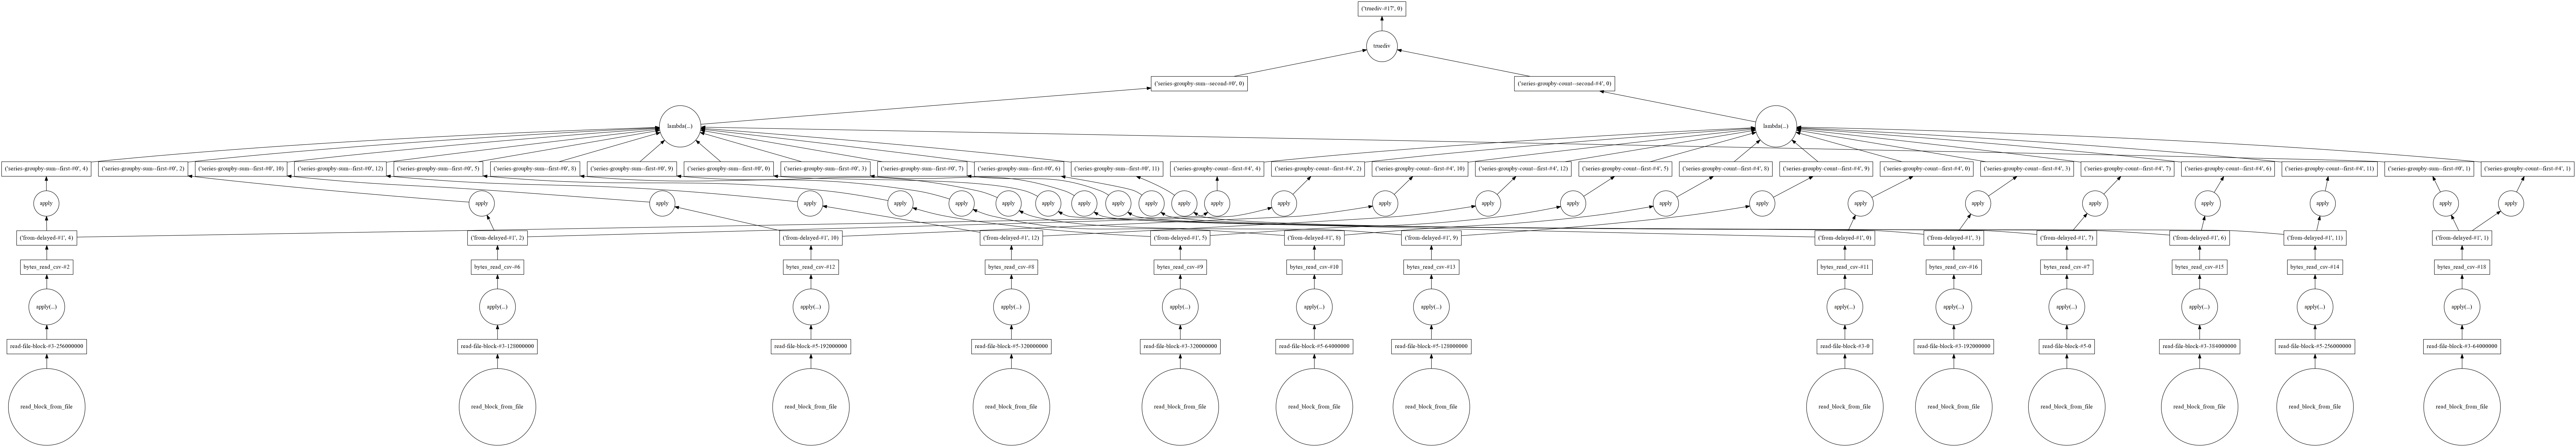

In [77]:
from dask.dot import dot_graph

dot_graph(result.dask)

In [41]:
import dask

## Getting started with Dask

Because Dask DataFrame implements much of the Pandas API, we eliminate the added complications of parallel computing or computing on large datasets by first working our analysis out on a small subset using Pandas.

If one makes sure they stick the to [subset of the Pandas API that Dask supports](http://dask.pydata.org/en/latest/dataframe-api.html), leveraging the power of Dask is as simple as changing the data ingest or creation call and adding a `.compute()` to the computation.

In [15]:
import pandas as pd
_df = pd.read_csv('LANDSAT_8.csv', parse_dates=['acquisitionDate'], nrows=100)

In [16]:
s = _df['DATA_TYPE_L1']